In [13]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import matplotlib as mpl

# customize matplotlib styles
mpl.rc('lines', linewidth=4) # default linewidth
mpl.rc('lines', dash_capstyle='round') # default dashed line capstyle
mpl.rc('lines', solid_capstyle='round') # default solid line capstyle
mpl.rc('xtick', labelsize=20) # default label size for xtick
mpl.rc('ytick', labelsize=20) # default label size for ytick
mpl.rc('axes', titlesize=30) # default title size
mpl.rc('axes', labelsize=25) # default label size for all axes
mpl.rc('legend', fontsize=20) # default fontsize for legends
mpl.rc('figure', titlesize=35) # default title size for figures with subplot

% matplotlib inline

# Definition of tube class

In [14]:
class tube:
    r = np.zeros((0,3))
    def __init__(self, coordinates):
        for node in coordinates:
            node = node.split(',')
            if (len(node) is 3):
                a = np.array([float(item) for item in node])
                a = a.reshape((1,3))
                self.r = np.concatenate((self.r, a), axis=0)
    
    def avg_y(self):
        return np.mean(self.r[:,1])
    def x(self):
        return self.r[:,0]
    def y(self):
        return self.r[:,1]
    def z(self):
        return self.r[:,2]

# Check height of tubes

In [15]:
directory = os.path.expanduser("~/research/cnt_mesh_fiber")

tubes = []

for i in range(1,100):
    filename = os.path.join(directory, "tube"+str(i)+".dat")
    if (not os.path.isfile(filename)):
        continue
    print("reading file: {}".format(filename))
    with open(filename) as file:
        for line in file:
            r = line.strip().split(";")
            r = r[1:]
            tubes.append(tube(r))

# make sure the last tube is stored and read properly
if (tubes[-1].r.shape!=tubes[0].r.shape): tubes.pop(-1)
            
print("number of tubes: {}".format(len(tubes)))
avg_y = np.array([tube.avg_y() for tube in tubes[:]])

avg_number_of_sections = np.mean([tube.r.shape[0] for tube in tubes])
print("average number of sections per tube: {}".format(int(avg_number_of_sections)))

reading file: /home/amirhossein/research/cnt_mesh_fiber/tube1.dat
number of tubes: 2514
average number of sections per tube: 16


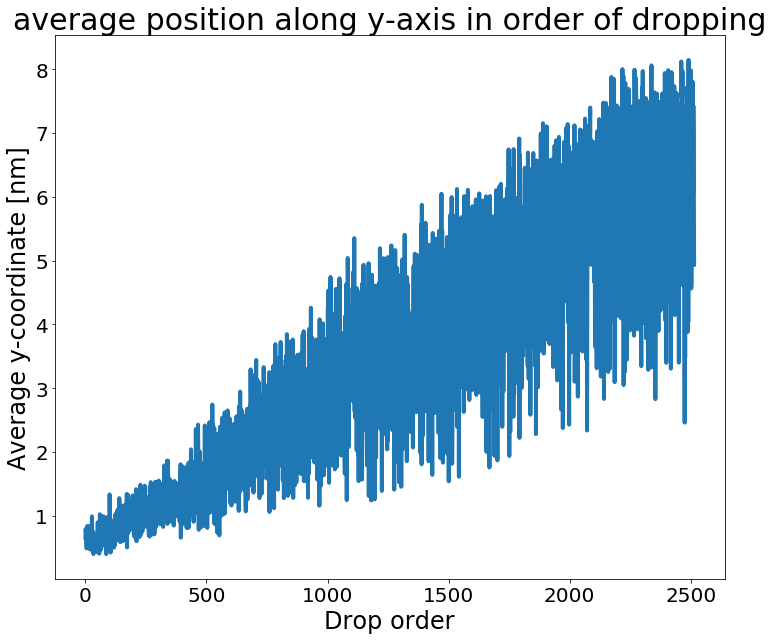

In [16]:
min_order, max_order = 0, len(tubes)
drop_order = np.linspace(min_order,max_order, max_order-min_order)

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)
ax.plot(drop_order,avg_y[min_order:max_order], linewidth=4)
ax.set_title("average position along y-axis in order of dropping",fontsize=30)
ax.set_xlabel("Drop order",fontsize=24)
ax.set_ylabel("Average y-coordinate [nm]",fontsize=24)
ax.tick_params(labelsize=20)

# Draw individual CNTs in the container

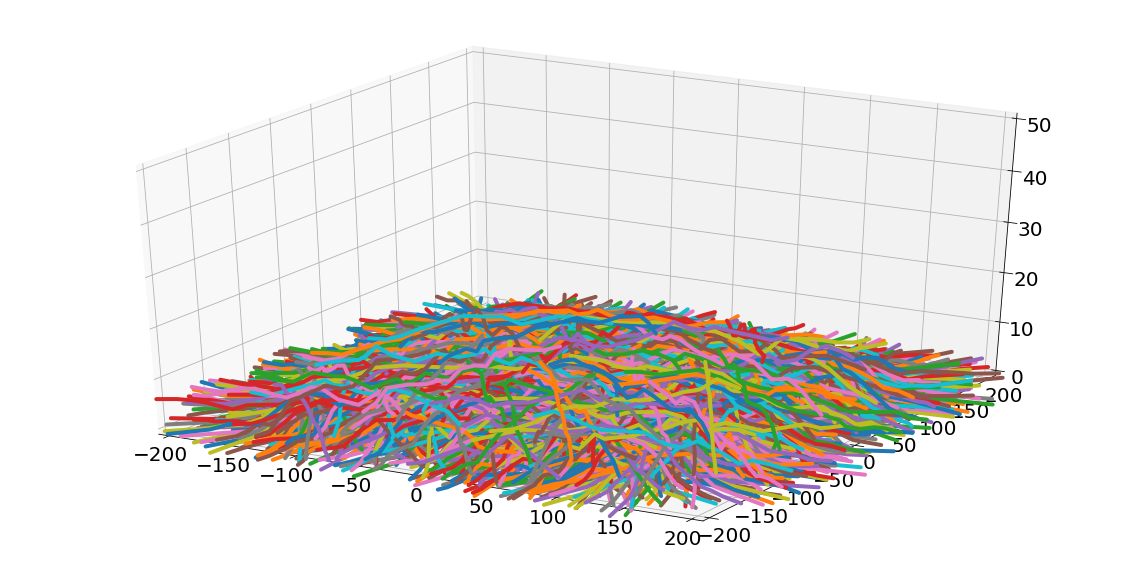

In [20]:
fig = plt.figure(figsize=(20,10))
# ax = fig.gca(projection='3d')
ax = fig.add_subplot(111,projection='3d')
# ax.set_aspect('equal')

begin=0
n_tube=len(tubes)-1

for t in tubes[begin:begin+n_tube]:
    ax.plot(t.x(), t.z(), t.y())

ax.set_xlim([-200,200])
ax.set_ylim([-200,200])
_ = ax.set_zlim([0,50])

# Working with quaternions for rations

Rotation is three dimension as a rotation by around axis $\vec{b}$ by angle $\alpha$. We can specify the rotation axis via [direction cosines](https://en.wikipedia.org/wiki/Direction_cosine)

$$ \cos(\beta_x) = \frac{\vec{b}.\hat{x}}{|b|} \quad,\quad \cos(\beta_y) = \frac{\vec{b}.\hat{y}}{|b|} \quad,\quad \cos(\beta_z) = \frac{\vec{b}.\hat{z}}{|b|} $$

Therefore, the quaternion elements, $\pmb{q}=[q_0, q_1, q_2, q_3]^T$, are given by 

$$
\begin{split}
q_0 = & ~\cos(\alpha/2) \\
q_1 = & ~\sin(\alpha/2) \cos(\beta_x) \\
q_2 = & ~\sin(\alpha/2) \cos(\beta_y) \\
q_3 = & ~\sin(\alpha/2) \cos(\beta_z) \\
\end{split}
$$

The rotation matrix for normalized quaternion is
$$
R = \begin{bmatrix}
q_0^2 + q_1^2 - q_2^2 - q_3^2 &  2(q_1 q_2 - q_0 q_3) &  2(q_0 q_2 + q_1 q_3) \\
2(q_1 q_2 + q_0 q_3) & q_0^2 - q_1^2 + q_2^2 - q_3^2 &  2(q_2 q_3 - q_0 q_1) \\
2(q_1 q_3 - q_0 q_2) & 2( q_0 q_1 + q_2 q_3) & q_0^2 - q_1^2 - q_2^2 + q_3^2 
\end{bmatrix}
$$



References:
- https://en.wikipedia.org/wiki/Conversion_between_quaternions_and_Euler_angles

In [45]:
def get_direction_cosine(axis):
    assert len(axis) is 3
    axis = axis / np.linalg.norm(axis)
    cosine = np.zeros((3,1))
    cosine[0] = axis.dot([1,0,0])
    cosine[1] = axis.dot([0,1,0])
    cosine[2] = axis.dot([0,0,1])
    return cosine

def get_quaternion(axis,alpha):
    beta = direction_cosine(axis)
    quaternion = np.zeros((4,1))
    quaternion[0] = np.cos(alpha/2)
    quaternion[1] = np.sin(alpha/2)*np.cos(beta[0])
    quaternion[2] = np.sin(alpha/2)*np.cos(beta[1])
    quaternion[3] = np.sin(alpha/2)*np.cos(beta[2])
    return quaternion

# gets rotation matrix from quaternion
def rotation_from_quaternion(q):
    R = np.zeros((3,3))
    R[0,0] = q[0]**2+q[1]**2-q[2]**2-q[3]**2
    R[0,1] = 2*(q[1]*q[2]-q[0]*q[3])
    R[0,2] = 2*(q[0]*q[2]+q[1]*q[3])
    R[1,0] = 2*(q[1]*q[2]+q[0]*q[3])
    R[1,1] = q[0]**2-q[1]**2+q[2]**2-q[3]**2
    R[1,2] = 2*(q[2]*q[3]-q[0]*q[1])
    R[2,0] = 2*(q[1]*q[3]-q[0]*q[2])
    R[2,1] = 2*(q[0]*q[1]+q[2]*q[3])
    R[2,2] = q[0]**2-q[1]**2-q[2]**2+q[3]**2    
    return R

axis = np.array([0,1,0])
cosine = get_direction_cosine(axis)
print("direction cosine: [{}, {}, {}]".format(cosine[0],cosine[1], cosine[2]))

alpha = np.pi/2

qt = get_quaternion(axis,alpha)
Rot  = rotation_from_quaternion(qt)

v = np.array([1,0,0],ndmin=2)
v = np.reshape(v,(3,1))
w = np.matmul(Rot,v)
print(w)


direction cosine: [[0.], [1.], [0.]]
[[0.35403671]
 [1.54030231]
 [0.45969769]]
